In [273]:
import numpy as np 
import matplotlib.pyplot as plt
import sklearn as sk
import skimage as ski
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Data Handling

In [274]:
cifar = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

In [275]:
# Taking a number of data points from each class
def get_N_from_each_class(n_sample, per_testing, x_train, y_train, x_test, y_test):

    num_test = int(per_testing*n_sample)
    num_train = int(n_sample - num_test)

    print(list(range(num_train)))
    mask = list(range(num_train))
    x_train = x_train[mask]
    y_train = y_train[mask]

    mask = list(range(num_test))
    x_test = x_test[mask]
    y_test = y_test[mask]

    y_train = y_train.ravel()
    y_test = y_test.ravel()

    return (x_train, y_train), (x_test, y_test)

n = 1000
(x_train, y_train), (x_test, y_test) = get_N_from_each_class(n,0.3, x_train, y_train, x_test, y_test)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [276]:
# extrating the features from the images
# method used: Central Moments

def extract_image_features(image , C = 3):
    '''
    Extracts the features from the image using the central moments method of order C
    It turns the image to grayscale, then calculates the central moments of order C
    
    Parameters:
    image: the image to be processed
    C: the moments order

    Returns:
    features: a vector of the features extracted from the image
    '''

    # turning the image to grayscale
    image = ski.color.rgb2gray(image)

    # calculating the central moments
    cal_moments = ski.measure.moments_central(image, order = C)

    # create an np array that contains zeroes 
    features = np.zeros(shape = int((C + 1) * ( C + 2) / 2))


    # turn the 2D array to 1D by putting only the needed values based on this equation 
    # p + q <= C 
    # if C = 3 the needed numbers are : 00 01 10 11 20 02 21 12 03 30 , size = 10 s
    current = 0;
    for i in range (C + 1):
        for j in range (C + 1):
            if(i + j <= C):
                features[current] = cal_moments[i][j]
                current = current + 1

                
    return features    



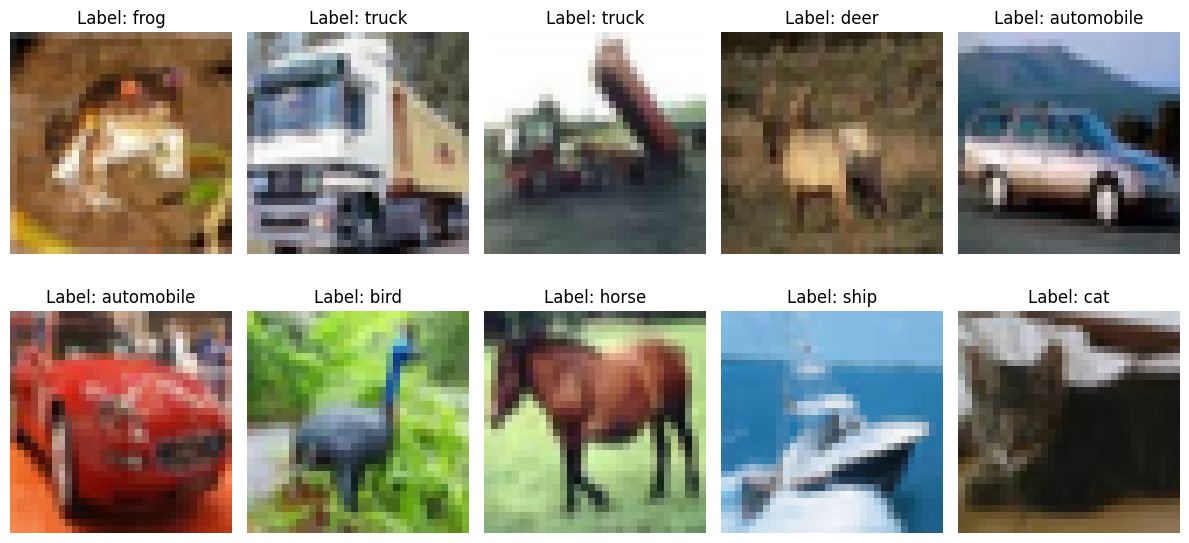

In [277]:
#Display a sample of images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    ax.axis('off')
    ax.set_title(f'Label: {labels[y_train[i]]}')
    
plt.tight_layout()
plt.show()


##### SVM 
<b>(An Example for Multi-Class Classification using SVM)</b>

https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

- Here is what we going to do for the SVM:
    * We will use the SVM implementation in sklearn
    * The parameters of the SVM will be chosen using grid search with cross validation
        * Degree for the polynomial kernel
        * C parameter for the SVM
            * C (Regularization Parameter): The `C` parameter is a positive scalar that controls the regularization strength. It influences the optimization process by balancing the desire to fit the training data well against the goal of keeping the model simple and avoiding overfitting.
            * Smaller values of C result in a wider margin, allowing more training points to be misclassified.
            * Larger values of C result in a narrower margin, forcing the optimizer to classify all training points correctly.
        * Gamma parameter for `rbf` , `poly` and `sigmoid` kernels
        * we will use both OVR and OVO strategies (`decision_function_shape` parameter)
    
    * We will Grid Search to find the best parameters for the SVM
    * We will use the `make_pipeline` 
    * We will use the `StandardScaler` to scale the data 

##### KNN 

( An Example for KNN Classification )

https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

* The parameter we are going to experiment with the value of K (number of neighbors)
* The same thing as in SVM we are going to use `make_pipeline` and `StandardScaler` 

In [278]:
C_Order = 10
num_of_features = int((C_Order + 1) * ( C_Order + 2) / 2)

# Extracting the features from the images
x_train_features = np.zeros(shape = (len(x_train), num_of_features))
x_test_features = np.zeros(shape = (len(x_test), num_of_features))

x_train_features = np.array([extract_image_features(x_train[i], C_Order) for i in range(len(x_train))])
x_test_features = np.array([extract_image_features(x_test[i], C_Order) for i in range(len(x_test))])


print(x_train_features.shape)
print(x_test_features.shape)
print(y_train.shape)
print(y_test.shape)


# Standardizing the data
scaler = StandardScaler()
x_train_features = scaler.fit_transform(x_train_features)
x_test_features = scaler.transform(x_test_features)


(700, 66)
(300, 66)
(700,)
(300,)


In [279]:

k_neighbours = 11

knn_model = KNeighborsClassifier(k_neighbours)

param_grid = {'n_neighbors': np.arange(1, 100)}

knn_grid = GridSearchCV(knn_model, param_grid)

knn_grid.fit(x_train_features, y_train)

print(f'Best score: {knn_grid.best_score_}')
print(f'Best parameters: {knn_grid.best_params_}')


k_neighbours = knn_grid.best_params_['n_neighbors']

knn_model = KNeighborsClassifier(k_neighbours)

knn_model.fit(x_train_features, y_train)

print(f'Train accuracy: {knn_model.score(x_train_features, y_train)}')

print(f'Test accuracy: {knn_model.score(x_test_features, y_test)}')





Best score: 0.20571428571428568
Best parameters: {'n_neighbors': 19}
Train accuracy: 0.30857142857142855
Test accuracy: 0.17
